# Vehicle Detection Project

This project's goal is to

#1 - Create a classifier that can identify a car
#2 - Create a pipeline that utilizes the classifier to work on images and/or video streams.
#3 - When using video, have the pipeline work with previous known locations of cars to simplify future searches.

In [1]:
#First, load up things we're definitely going to need
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

## Training a classifier

The datasets we're using are provided by Udacity and assumed to have been extracted into the `data/` folder, separated into `vehicle` and `non-vehicle` folders to keep the dataset labelled. For space reasons, they are not included in the repository, but are provided here:

* [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

Here we load up the dataset:

In [2]:
dataset = { "vehicles": [], "nonvehicles": [] }

In [3]:
# Load all of the dataset images
vehicle_dataset_names = [
    "GTI_Far",
    "GTI_Left",
    "GTI_MiddleClose",
    "GTI_Right",
    "KITTI_extracted"
]

non_vehicle_dataset_names = [
    "Extras",
    "GTI"
]

from glob import glob

def get_filenames(folder):
    return glob(folder + "/*.png")

for vehicle_dataset in vehicle_dataset_names:
    dataset['vehicles'] += get_filenames("./data/vehicles/" + vehicle_dataset)
    
for nonvehicle_dataset in non_vehicle_dataset_names:
    dataset['nonvehicles'] += get_filenames("./data/non-vehicles/" + nonvehicle_dataset)


In [4]:
# We need to know if the two datasets are approximately equal before moving on
print("Number of vehicles present in dataset:", len(dataset["vehicles"]))
print("Number of non-vehicles present in dataset:", len(dataset["nonvehicles"]))

Number of vehicles present in dataset: 8792
Number of non-vehicles present in dataset: 8968


We needed to ensure that there were roughly the same number of samples in each vehicle and non-vehicle datasets. Having an imbalance would increase the likelihood that any classifier we created would lean too heavily in just classifying a given input as the majority dataset.

With the above #s, it seems that the culmination of all the datasets provided leads to an approximately equal outcome - we can work with this without having to cull any samples.

Please note that we're loading with OpenCV and then converting to RGB to avoid scaling issues with PNGs.

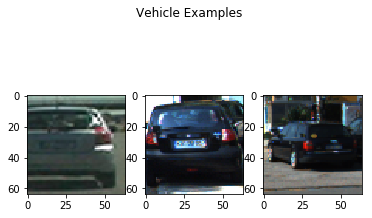

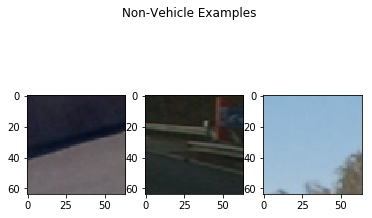

In [5]:
# Load up a couple of random examples of each
from random import randint

example_images_positive = []
example_images_negative = []

fig = plt.figure()
fig.suptitle("Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['vehicles'][randint(0, len(dataset['vehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

fig = plt.figure()
fig.suptitle("Non-Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3, i + 1)
    img = cv2.imread(dataset['nonvehicles'][randint(0, len(dataset['nonvehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
# Now we have to create a singular features/labels dataset

features = []
labels = []

for data in dataset['vehicles']:
    features.append(data)
    labels.append("vehicle")

for data in dataset['nonvehicles']:
    features.append(data)
    labels.append("nonvehicle")

print(len(features), len(labels))

17760 17760


### Splitting the Dataset

Now that we have the datasets loaded, we need to split them into training and test datasets.

To do this, we'll make use of sklearn's helper functions.

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(features, labels, test_size=0.25)

print(len(train_imgs), len(test_imgs), len(test_imgs) / (len(test_imgs) + len(train_imgs)) )

13320 4440 0.25


## Color Histogram

As part of building a car fingerprint, I'll build a color histogram of the car. But what color spaces are useful? Let's explore some of the test images and see what color spaces give us useful information.

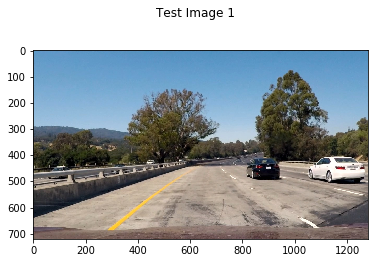

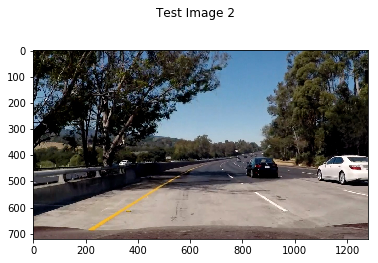

In [8]:
# Load up two test images
test_img1 = cv2.cvtColor(cv2.imread("./test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
test_img2 = cv2.cvtColor(cv2.imread("./test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

plt.figure()
plt.suptitle("Test Image 1")
plt.imshow(test_img1)
plt.show()
plt.figure()
plt.suptitle("Test Image 2")
plt.imshow(test_img2)
plt.show()

### Functionality to Handle 3d Plots

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(img, colorspace, axis_limits=((0, 255), (0, 255), (0, 255))):
    
    if colorspace is not "RGB":
        colorspace_img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + colorspace))
    else:
        colorspace_img = img
    
    axis_labels = colorspace
    axis_labels = list(axis_labels)
    color_channels = img / 255
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        colorspace_img[:, :, 0].ravel(),
        colorspace_img[:, :, 1].ravel(),
        colorspace_img[:, :, 2].ravel(),
        c=color_channels.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

### RGB Exploration

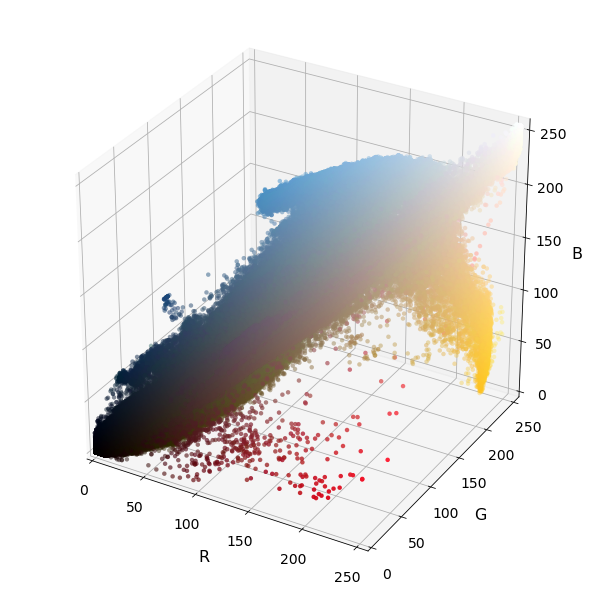

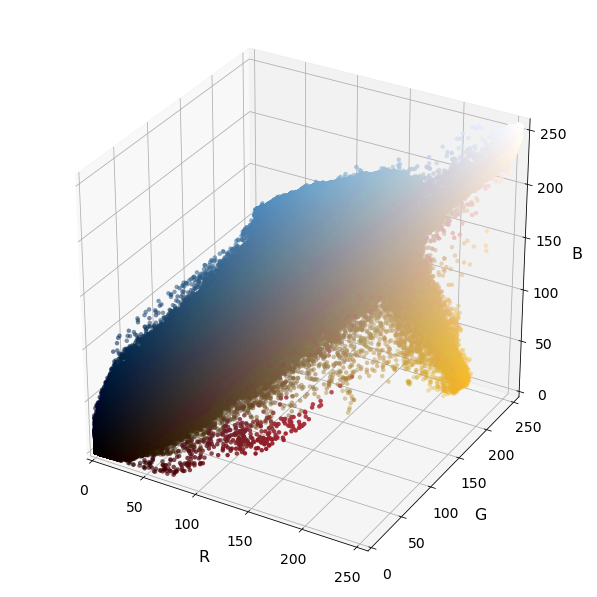

In [10]:
plot3d(test_img1, "RGB")
plot3d(test_img2, "RGB")

### HLS Exploration

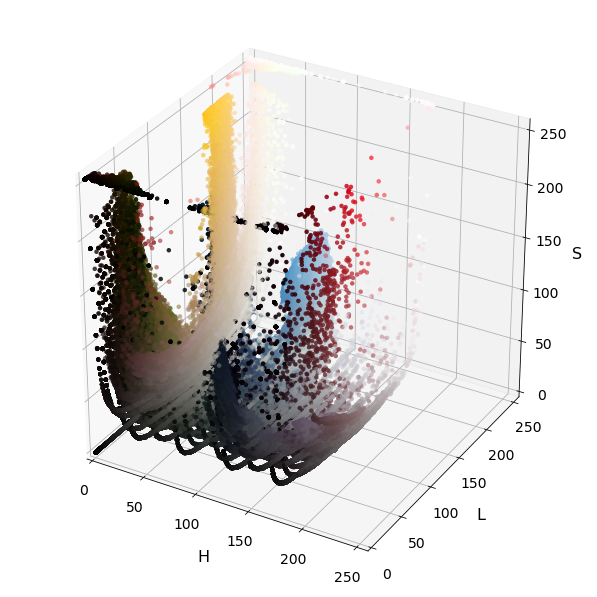

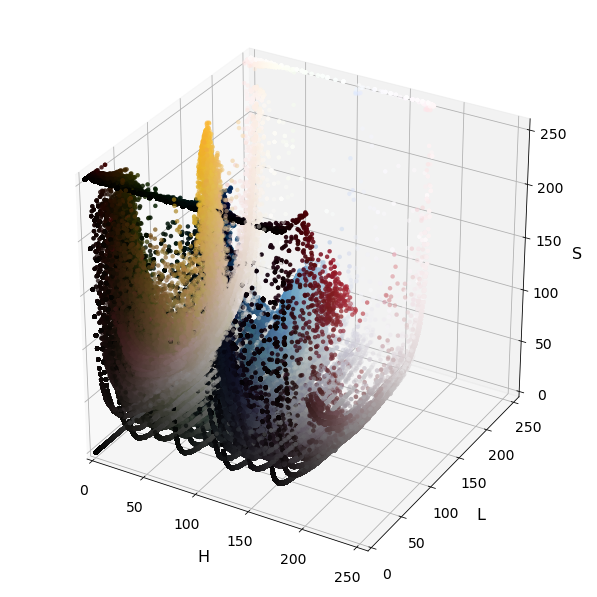

In [12]:
plot3d(test_img1, "HLS")
plot3d(test_img2, "HLS")

### LUV Exploration

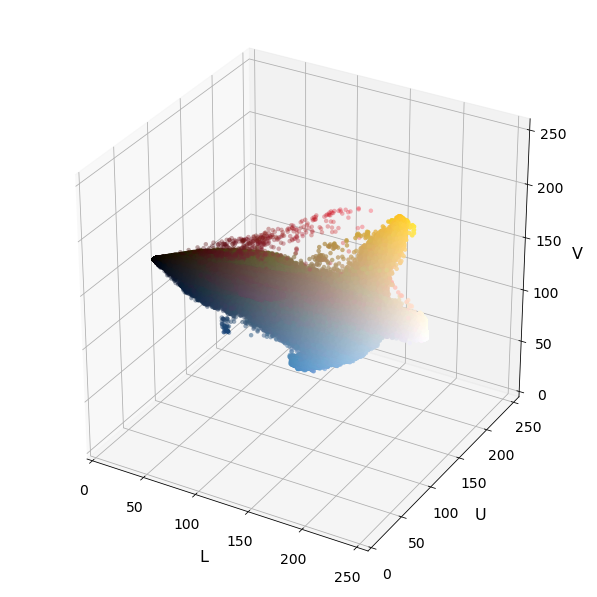

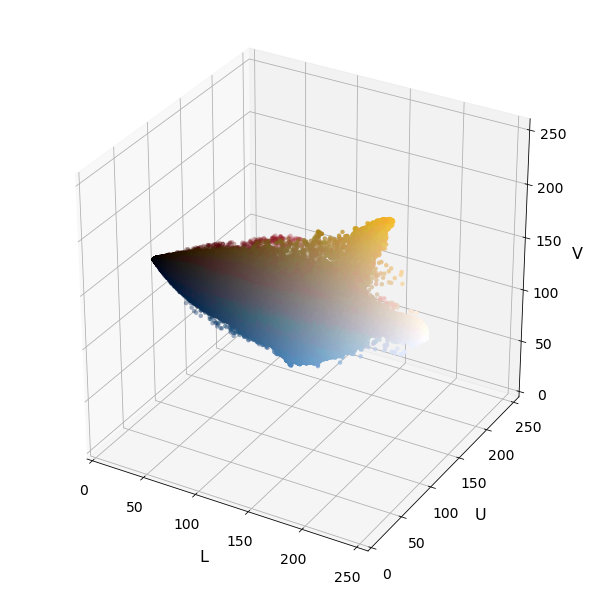

In [13]:
plot3d(test_img1, "LUV")
plot3d(test_img2, "LUV")

### HSV Exploration

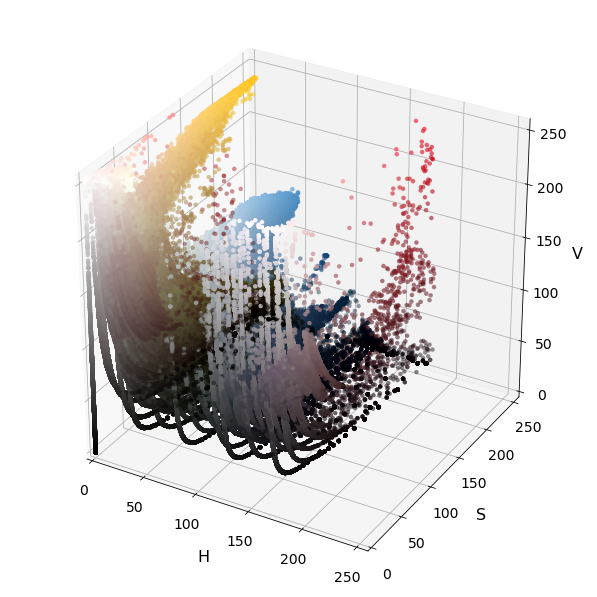

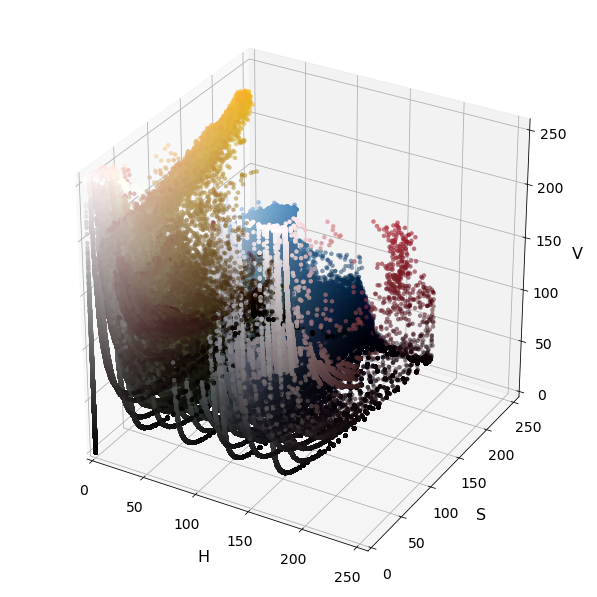

In [14]:
plot3d(test_img1, "HSV")
plot3d(test_img2, "HSV")

### Findings for Color Exploration

Above, I looked at two sample images of two cars each in the RGB, HLS, LUV, and HSV color spaces. The goal was to see what colorspaces, if any, have significantly noticeable separation of pixels related to car relative to surrounding pixels.

RGB and LUV colorspaces seemed to have the pixels for the images group up too closely to see anything identifiable as a separate entity between car and background.

The HLS And HSV color spaces are definitely identifiable - specifically across the Hue and Lightness channels for HLS, and amongst the Hue and Value channels.

Since it seems that the HSL colorspace is slightly more "separated", we'll use that for dealing with colors.

## Spatial Binning of Color

In order to reduce the amount of features being processed, we're going to create a function that spatically bins the color image. This consists of:

#1 If the colorspace requested is not RGB, convert the image to the approrpiate color space
#2 Resize the image of the chosen image to a smaller size, like 32x32 pixels
#3 "Ravel" the image, into a straight set of features (instead of a 2 dimensional matrix

In [10]:
def color_bin_spatial(img, color_space, channels_kept=None, size=(32, 32)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))

    bins = cv2.resize(img, size)

    if channels_kept is None:
        return bins.ravel()
    else:
        kept_bins = []
        for channel in channels_kept:
            index = color_space.find(channel)
            if index is -1:
                raise Error("The provided channel " + " channel is not found in the color space of " + color_space)

            single_channel = bins[:,:,index]
            kept_bins.append(single_channel.ravel())
            
        #stack the kept_bins together
        return np.concatenate(kept_bins)

## Color Histogram for Colors

In order to better generalize the colors for matching against like-cars, we can just grab a histogram of each channel in a given image (or array of provided channels)

In [46]:
def histograms(img, color_space="RGB", channels_kept=None, nbins=32, bins_range=(0, 256)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))
        
    if channels_kept is None:
        channels_kept = color_space
        
    c_indexes = []
    for c in channels_kept:
        c_indexes.append(color_space.find(c))
    
    channel_histograms = []
    for channel_index in range(0, img.shape[2]):
        if channel_index in c_indexes:
            channel_histogram = np.histogram(img[:,:,channel_index], bins=nbins, range=bins_range)[0]
            channel_histograms.append(channel_histogram)
        
    histogram_features = np.concatenate(channel_histograms)
    
    return histogram_features

## Histogram of Oriented Gradients (HOG)

We will be using the `HOG` method in order to create a "fingerprint" of a given area in order to check it to see if it is similar to a car.

In [27]:
from skimage.feature import hog

def get_hog_features(img, debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if debug is True:
        features, hog_image = hog(  gray,\
                                    orientations=9,\
                                    pixels_per_cell=(8,8),\
                                    cells_per_block=(2,2),\
                                    transform_sqrt=True,\
                                    feature_vector=False,\
                                    visualise=debug\
                                 )
        plt.figure()
        plt.suptitle("HOG Visualization")
        plt.imshow(hog_image)
        plt.show()
    else:
        features = hog(  gray,\
                                    orientations=9,\
                                    pixels_per_cell=(8,8),\
                                    cells_per_block=(2,2),\
                                    transform_sqrt=True,\
                                    feature_vector=False,\
                                    visualise=debug\
                                 )
    return features
        

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


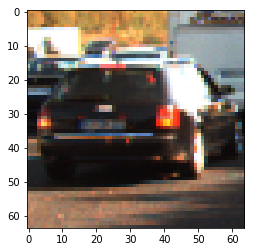

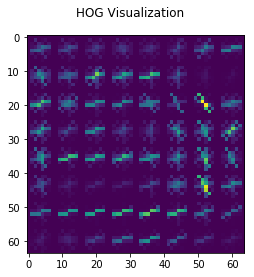

In [17]:
# Test the above function with a test image
randImage = cv2.cvtColor(cv2.imread(train_imgs[randint(0, len(train_imgs))]), cv2.COLOR_BGR2RGB)

plt.imshow(randImage)
hog_features = get_hog_features(randImage, debug=True)

## Build dataset

We can't load all the images into memory (well, maybe, but it's not a great idea) - but we can probably store the hog features map plus the spatially binned color channels that we want to pay attention too for each image for training.

We'll define two functions - one that, given a dataset, will maintain its order and generate the output for the dataset - `convert_dataset`. That will require something that will call and append the color binning (normalized) plus the hog features - we'll do that in `convert_sample`. Inside the `convert_sample` function, we'll be getting the color bin spatial features, getting the hog features (and raveling it), combining them, and then normalizing the sample to prevent any feature from overpowering the others.

In [18]:
from sklearn.preprocessing import StandardScaler

In [65]:
def convert_sample(img): 
    features = []
    color_bin_hs = color_bin_spatial(img, "HLS", channels_kept=["H", "S"])
    color_bin_v = color_bin_spatial(img, "HSV", channels_kept=["V"])
    features.append(color_bin_hs)
    features.append(color_bin_v)
    
    histogram_hs = histograms(img, color_space="HLS", channels_kept=["H", "S"])
    histogram_v = histograms(img, color_space="HSV", channels_kept=["V"])
    features.append(histogram_hs)
    features.append(histogram_v)
    
    hog = get_hog_features(img)
    hog = hog.ravel()
    features.append(hog)
    
    #Append the two features
#     sample = [np.concatenate([color_bin, hog]).astype(np.float64)]
    sample = np.concatenate(features)
    
    return sample
#     print("sample", sample)
#     #Normalize the sample to prevent any feature from overpowering another
#     scaler = StandardScaler().fit([sample])
#     print("scaled", scaler.transform([sample]))
#     return scaler.transform([sample])

In [20]:
def convert_dataset(dataset):
    converted = []
    
    for data in dataset:
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        converted.append(convert_sample(img))
        
    return converted

In [67]:
train_features = convert_dataset(train_imgs)
test_features = convert_dataset(test_imgs)

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[  2.70000000e+01   3.30000000e+01   4.50000000e+01 ...,   1.40796206e-03
   0.00000000e+00   0.00000000e+00]


/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


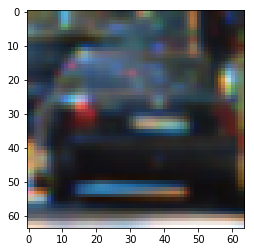

In [66]:
test = cv2.imread(train_imgs[10])
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)
result = convert_sample(test)
print(result)

In [68]:
print(len(train_features), len(test_features))

13320 4440


## Normalization

Why do we normalize etc

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

## SVM

SVM Explanation

In [73]:
from sklearn.svm import LinearSVC
from time import time

svc = LinearSVC()
# Check the training time for the SVC
t = time()
svc.fit(train_features, train_labels)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(test_features, test_labels), 4))


3.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9865
